# MNIST Classification task

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

## Load the data

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

# Split dataset into train and test sets

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Explore the data

digit label:5


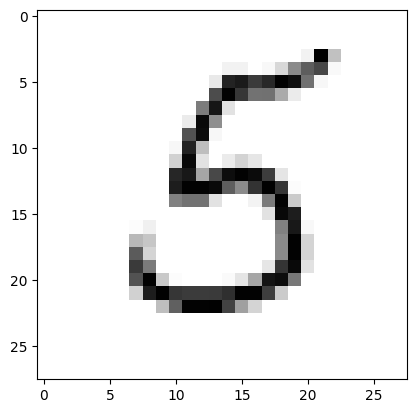

In [57]:
some_digit = X_train[0]
some_label = y_train[0]
plt.imshow(some_digit.reshape(28, 28), cmap='Greys')
print(f'digit label:{some_label}')

## Train the binary classifier for first number

In [14]:
y_train_5 = y_train == '5'

y_train_5.shape

(56000,)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])


array([ True])

## Measure the first selected model accuracy

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.97192907, 0.96855413, 0.96024858])

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[50287,   673],
       [ 1180,  3860]])

In [23]:
from sklearn.metrics import precision_score, recall_score

pr_score = precision_score(y_train_5, y_train_pred)
rec_score = recall_score(y_train_5, y_train_pred)

pr_score, rec_score

(np.float64(0.8515332009706597), np.float64(0.7658730158730159))

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.8064347644416588)

### The precision/recall trade off

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
threshold = 3000

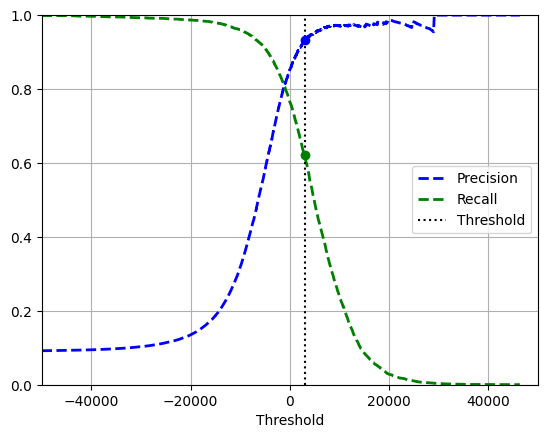

In [38]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g--', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='Threshold')
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis((-50000, 50000, 0, 1))
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

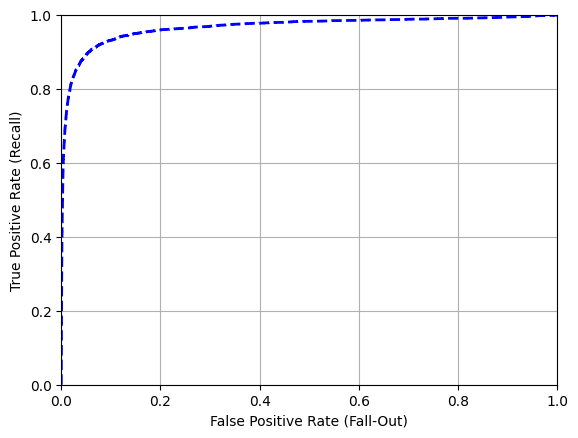

In [41]:
plt.plot(fpr, tpr, 'b--', label='ROC', linewidth=2)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis((0, 1, 0, 1))
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9672937302210262)

### Let's compare the PR trade off with another model

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [46]:
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [50]:
y_proba_forest[:2]

array([[0.25, 0.75],
       [0.99, 0.01]])

In [51]:
y_scores_forest = y_proba_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

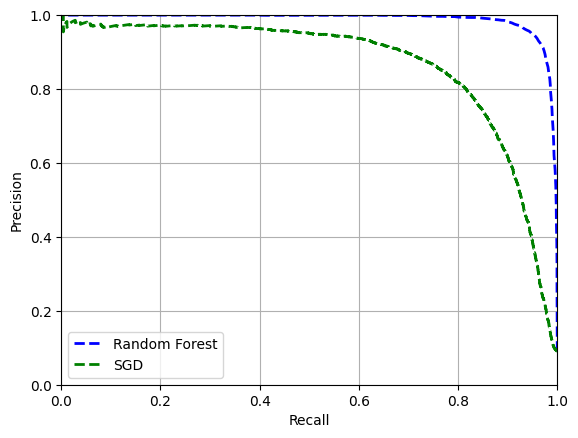

In [55]:
plt.plot(recalls_forest, precisions_forest, 'b--', label='Random Forest', linewidth=2)
plt.plot(recalls, precisions, 'g--', label='SGD', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.axis((0, 1, 0, 1))
plt.legend(loc="lower left")
plt.show()

## Multiclass Classification

In [56]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [58]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [59]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.72,  4.79,  8.28,  2.73,  9.3 ,  7.25, -0.29,  6.25,
         1.75]])

#### As we know SVC using OvO strategy, let's force it to use OvR strategy and compare the results

In [64]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [67]:
ovr_clf.predict([some_digit]), len(ovr_clf.estimators_)

(array(['5'], dtype='<U1'), 10)

In [66]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['5'], dtype='<U1')

## Error analysis

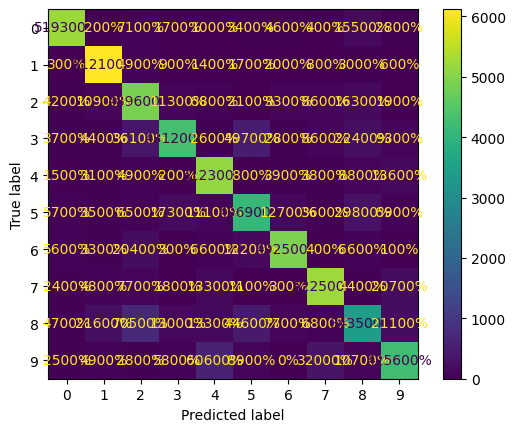

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

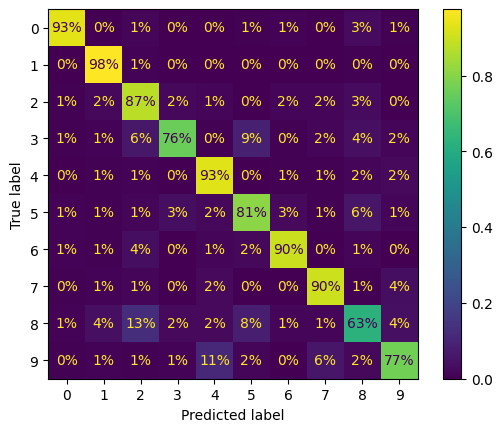

In [71]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')

### Let's try another model - KNeighbourClassifier. And also try to fine-tune our model

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
}
gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
gs.fit(X_train, y_train)
gs.best_score_, gs.best_params_

(np.float64(0.9697142726207574), {'n_neighbors': 3, 'weights': 'distance'})

## Finally evaluate the model on the test set

In [79]:
final_model = gs.best_estimator_
accuracy = gs.score(X_test, y_test)
accuracy

1.0